# Homework 5

## Problem 1 (150 points)

Consider a slightly asymmetric wellbore in an otherwise symmetric and homogenous medium in which the interior wellbore pressure $p_0$ is held constant.  Assuming steady-state, plane-strain and *undrained* conditions, compute the displacements and pressures on the given mesh.  The mesh information is provided in the following files with short descriptions of thier contents.

[coords.csv](http://johnfoster.pge.utexas.edu/PGE383-AdvGeomechanics/files/coords.csv) - the geometric node locations for all nodes.  They are listed in $x,y$ pairs with each line corresponding to a global node index starting with 1 and proceding in sequence.

[connect.csv](http://johnfoster.pge.utexas.edu/PGE383-AdvGeomechanics/files/connect.csv) - the connectivity arrays.  Each line contains the global node numbers of an element with local node numbering as specified in the schematic. For the pressue interpolates, only use the first 4 which will coorespond to the corners of the element.

[nodeset1.csv](http://johnfoster.pge.utexas.edu/PGE383-AdvGeomechanics/files/nodeset1.csv) - the nodes on the interior boundary.  Use these nodes to specify the interior pressure, $p_0$.

[nodeset2.csv](http://johnfoster.pge.utexas.edu/PGE383-AdvGeomechanics/files/nodeset2.csv) - the nodes on the exterior boundary.  Use these nodes to specify the far-field pressure, $p_{\infty}$.

[nodeset3.csv](http://johnfoster.pge.utexas.edu/PGE383-AdvGeomechanics/files/nodeset3.csv) - the nodes on the horizontal symmetric boundary (indicated in blue in the schematic).

[nodeset4.csv](http://johnfoster.pge.utexas.edu/PGE383-AdvGeomechanics/files/nodeset4.csv) - the nodes on the horizontal symmetric boundary (indicated in red in the schematic).

Assume zero fluid compressibility, i.e. $1/M = 0$ and the following dimensionless properties $\alpha = 1, \nu = 0.3, \mu = 1$ for Biot's coefficient, Poisson's ratio, and shear modulus, respectively.  Apply an interior pressue $p_0=5$ and a constant far-field pressure $p_{\infty}=1$.  Assume the far field boundary is stress-free as well.  Create plots of the stress fields for $\sigma_{xx}$, $\sigma_{yy}$, and $\sigma_{xy}$ as well as the pressures.

<img src="images/assignment5.png">

In [1]:
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

class TwoDimCoupledFEM():
    
    def __init__(self, nodes, connect, mu, nu, alpha, bc_nodes=[], bc_vals=[]):
        
        self.X = nodes[:,0]
        self.Y = nodes[:,1]
        self.connect = (connect - 1)
        
        self.nu = nu
        self.mu = mu
        self.alpha = alpha
        
        self.num_elem = len(self.connect)
        
        
    def dNdxi(self, xi, eta):
        
        return [eta/4. - eta**2/4. - (eta*xi)/2. + (eta**2*xi)/2.,
                -eta/4. + eta**2/4. - (eta*xi)/2. + (eta**2*xi)/2.,
                eta/4. + eta**2/4. + (eta*xi)/2. + (eta**2*xi)/2.,
                -eta/4. - eta**2/4. + (eta*xi)/2. + (eta**2*xi)/2.,eta*xi - eta**2*xi,
                0.5 - eta**2/2. + xi - eta**2*xi,-(eta*xi) - eta**2*xi,
                -0.5 + eta**2/2. + xi - eta**2*xi,-2*xi + 2*eta**2*xi]
                
                
    def dNdeta(self, xi, eta):
        
        return [xi/4. - (eta*xi)/2. - xi**2/4. + (eta*xi**2)/2.,
                -xi/4. + (eta*xi)/2. - xi**2/4. + (eta*xi**2)/2.,
                xi/4. + (eta*xi)/2. + xi**2/4. + (eta*xi**2)/2.,
                -xi/4. - (eta*xi)/2. + xi**2/4. + (eta*xi**2)/2.,
                -0.5 + eta + xi**2/2. - eta*xi**2,-(eta*xi) - eta*xi**2,
                0.5 + eta - xi**2/2. - eta*xi**2,eta*xi - eta*xi**2,-2*eta + 2*eta*xi**2]
    
    def Nu(self, xi, eta):
                
        return [(eta*xi)/4. - (eta**2*xi)/4. - (eta*xi**2)/4. + (eta**2*xi**2)/4.,
                -(eta*xi)/4. + (eta**2*xi)/4. - (eta*xi**2)/4. + (eta**2*xi**2)/4.,
                (eta*xi)/4. + (eta**2*xi)/4. + (eta*xi**2)/4. + (eta**2*xi**2)/4.,
                -(eta*xi)/4. - (eta**2*xi)/4. + (eta*xi**2)/4. + (eta**2*xi**2)/4.,
                -eta/2. + eta**2/2. + (eta*xi**2)/2. - (eta**2*xi**2)/2.,
                xi/2. - (eta**2*xi)/2. + xi**2/2. - (eta**2*xi**2)/2.,
                eta/2. + eta**2/2. - (eta*xi**2)/2. - (eta**2*xi**2)/2.,
                -xi/2. + (eta**2*xi)/2. + xi**2/2. - (eta**2*xi**2)/2.,
                1 - eta**2 - xi**2 + eta**2*xi**2]
    
    
    def Np(self, xi, eta):
        
        return [1 / 4. * (-1 + eta) * (-1 + xi),
                -(1 / 4.) * (-1 + eta) * (1 + xi), 
                1 / 4. * (1 + eta) * (1 + xi),
                -(1 / 4.) * (1 + eta) * (-1 + xi)]
    
    
    def compute_jacobian_matrix_and_inverse(self, xi, eta):
        
        x = self.X
        y = self.Y
        con = self.connect
        
        J11 = np.dot(x[con], self.dNdxi(xi, eta))
        J12 = np.dot(y[con], self.dNdxi(xi, eta))
        J21 = np.dot(x[con], self.dNdeta(xi, eta))
        J22 = np.dot(y[con], self.dNdeta(xi, eta))
        
        self.detJ = J11 * J22 - J12 * J21
        
        self.Jinv11 =  J22 / self.detJ
        self.Jinv12 = -J12 / self.detJ
        self.Jinv21 = -J21 / self.detJ
        self.Jinv22 =  J11 / self.detJ
        
        
    def compute_B_matrix(self, xi, eta):
        
        self.compute_jacobian_matrix_and_inverse(xi, eta)
        
        dNxi = self.dNdxi(xi, eta)
        dNeta = self.dNdeta(xi, eta)
        
        Nmat = np.zeros((4, 2 * len(dNxi)))
        Nmat[0,0::2] = dNxi
        Nmat[1,0::2] = dNeta
        Nmat[2,1::2] = dNxi
        Nmat[3,1::2] = dNeta
        
        zero = np.zeros(len(self.detJ))
        
        Jmat = np.array([[self.Jinv11, self.Jinv12, zero, zero],
                         [self.Jinv21, self.Jinv22, zero, zero],
                         [zero, zero, self.Jinv11, self.Jinv12],
                         [zero, zero, self.Jinv21, self.Jinv22]])
        
        Dmat = np.array([[1.,0.,0.,0.],[0.,0.,0.,1.],[0.,1.,1.,0.]])
        
        #B = D * J * N
        return np.einsum('ij,jk...,kl',Dmat,Jmat,Nmat)
        
        
    def compute_stiffness_integrand(self, xi, eta, nu, mu):
            
        Ey = 2 * mu * (1 + nu)
            
        c11 = Ey * (1 - nu * nu) / ((1 + nu) * (1 - nu - 2 * nu * nu))
        c12 = Ey * nu / (1 - nu - 2 * nu * nu)
        c66 = Ey / (2 * (1 + nu))
            
        Cmat = np.array([[c11, c12, 0], [c12, c11, 0], [0, 0, c66]]);
            
        self.Bmat = self.compute_B_matrix(xi, eta)
            
        #ke_{il} = B_{ji} C_{jk} B_{kl} \det(J)
        return np.einsum('...ji,jk,...kl,...',self.Bmat,Cmat,self.Bmat,self.detJ)
    
    
    def compute_coupling_integrand(self, xi, eta, alpha):
        
        #ke = B^t * C * B
        m = np.array([1.0, 1.0, 0.0]) * alpha
        
        Np = self.Np(xi, eta)
        
        return np.einsum('...ij,i,k,...',self.Bmat,m,Np,self.detJ)
    
    
    def integrate_element_matrices(self):
            
        #Use 3 x 3 Gauss integration
        wts = [5 / 9., 8 / 9., 5 / 9.]
        pts = [-np.sqrt(3 / 5.), 0.0, np.sqrt(3 / 5.)]
            
        ke = np.zeros((self.num_elem, 18, 18))
        qe = np.zeros((self.num_elem, 18, 4))
            
        for i in range(3):
            for j in range(3):
                ke += wts[i] * wts[j] * self.compute_stiffness_integrand(pts[i], pts[j], self.nu, self.mu)
                qe += wts[i] * wts[j] * self.compute_coupling_integrand(pts[i], pts[j], self.alpha)
                    
        return (ke,qe)
    
    
    def compute_stress_at_gauss_point(self, xi, eta, disp):
        
        mu = self.mu
        nu = self.nu
        
        Ey = 2 * mu * (1 + nu)
            
        c11 = Ey * (1 - nu * nu) / ((1 + nu) * (1 - nu - 2 * nu * nu))
        c12 = Ey * nu / (1 - nu - 2 * nu * nu)
        c66 = Ey / (2 * (1 + nu))
            
        Cmat = np.array([[c11, c12, 0], [c12, c11, 0], [0, 0, c66]]);
            
        Bmat = self.compute_B_matrix(xi, eta)
        
        elem_disp = disp[self.connect].reshape(-1,18)
        
        #stress_{i} = C_{ik} B_{kl} disp{l}
        return np.einsum('ik,...kl,...l',Cmat,Bmat,elem_disp).reshape(-1,3)
    
    
    def compute_stress(self, disp):
            
        #Gauss points
        pts = [-np.sqrt(3 / 5.), 0.0, np.sqrt(3 / 5.)]
            
        return np.array([[ self.compute_stress_at_gauss_point(i, j, disp) for i in pts ] for j in pts])
    
    
    def compute_gauss_point_locations(self, coords):
            
        #Gauss points
        pts = [-np.sqrt(3 / 5.), 0.0, np.sqrt(3 / 5.)]
        
        X = coords[:,0][self.connect]
        Y = coords[:,1][self.connect]
            
        xloc = np.array([[ np.dot(X, self.Nu(i, j)) for i in pts ] for j in pts]).flatten()
        yloc = np.array([[ np.dot(Y, self.Nu(i, j)) for i in pts ] for j in pts]).flatten()
        
        return (xloc, yloc)
    
    
    def assemble(self):
        
        #Construct a DOF map.  We'll start by assuming that every node has 3 DOF
        #this is obviously not true, but we'll correct it.
        fake_dof_map = np.zeros(3*len(self.X), dtype=np.int64).reshape(-1, 3)
        
        #The nodes that actually have pressue DOF's are the "corner" nodes of the element
        #or the first 4 nodes in each row of the connectivity array, let's select the others
        no_pressure_dof_nodes = (self.connect[:,4:]).flatten()
        
        #Now for these nodes that do not have pressure DOF's, we'll "flag" those DOFs with a -1
        fake_dof_map[:,2][no_pressure_dof_nodes] = -1
        fake_dof_map = fake_dof_map.flatten()
        
        #Now the rest of the DOF indices are not monotonically increasing (we removed some of them
        #and replaced them with -1's), so now we need to replace the non -1 entries with a monotonically
        #increasing DOF map that corresponds to the total number of DOF's.  First let's figure out
        #how many total DOF's ther are, this corresponds to wherever there are 0's in the fake_dof_map
        total_dof = (fake_dof_map == 0).sum()
        
        #Create a monotonically increasing range from 0 to the total_dof
        dof_range = np.arange(total_dof, dtype=np.int64)
        
        #Replace the 0's in the fake_dof_map with the monotonically increasing range
        fake_dof_map[np.where(fake_dof_map != -1)] = dof_range
        
        #Create the real dof_map, there will still be -1 "flags" in the third column
        self.dof_map = fake_dof_map.reshape(-1,3)
        
        #Allocate global stiffness matrix and r.h.s vector
        self.K = np.zeros((total_dof, total_dof), dtype=np.double)
        self.F = np.zeros(total_dof, dtype=np.double)
        
        #The DOF indices cooresponding to displacement
        idx_disp = (self.dof_map[:,:2][self.connect]).reshape(-1,18)
        
        #The DOF indices cooresponding to pressure, they should not have any -1's
        #because we only choose those that in the first 4 columns of each row in
        #the connectivity
        idx_pres = self.dof_map[:,-1][self.connect[:,:4]]
        
        #Integrate element stiffness matrices
        ke, qe = self.integrate_element_matrices()
        
        #Assemble into global stiffness matrix
        for i in range(self.num_elem):
            
            idx_grid_disp = np.ix_(idx_disp[i], idx_disp[i])
            self.K[idx_grid_disp]  += ke[i]
            
            idx_grid_pres = np.ix_(idx_disp[i], idx_pres[i])
            self.K[idx_grid_pres] += qe[i]
            
            idx_grid_pres = np.ix_(idx_pres[i], idx_disp[i])
            self.K[idx_grid_pres] += qe[i].T
            
            
    def apply_essential_bc(self, nodes, values, dof="x"):
        
        node_idx = nodes - 1
        
        if dof == "x":
            dof_idx = 0
        elif dof == "y":
            dof_idx = 1
        elif dof == "p":
            dof_idx = 2
        
        row_replace = np.zeros(len(self.K))
        
        for value_idx, node in enumerate(node_idx):        
            
            row_idx = self.dof_map[node][dof_idx]
            
            self.K[row_idx] = row_replace
            self.K[row_idx,row_idx] = 1
            
            self.F[row_idx] = values[value_idx]
            
            
    def solve(self):
        
        self.K = scipy.sparse.csr_matrix(self.K)
        
        return scipy.sparse.linalg.spsolve(self.K,self.F)

In [2]:
coords = np.loadtxt("coords.csv", delimiter=',', dtype=np.double)
connect = np.loadtxt("connect.csv", delimiter=',', dtype=np.int64)
ns1 = np.loadtxt("nodeset1.csv", delimiter=',', dtype=np.int64)
ns2 = np.loadtxt("nodeset2.csv", delimiter=',', dtype=np.int64)
ns3 = np.loadtxt("nodeset3.csv", delimiter=',', dtype=np.int64)
ns4 = np.loadtxt("nodeset4.csv", delimiter=',', dtype=np.int64)

problem = TwoDimCoupledFEM(coords, connect, nu=0.3, mu=1, alpha=1)

problem.assemble()

problem.apply_essential_bc(ns3,np.zeros(len(ns3)),dof="y")
problem.apply_essential_bc(ns4,np.zeros(len(ns4)),dof="x")

#ns1 includes displacement nodes on the interior, we can't apply pressure
#to these, so first we modify ns1 to include only pressure nodes
ns1_pres = np.intersect1d(ns1,connect[:,:4].flatten())
problem.apply_essential_bc(ns1_pres,5*np.ones(len(ns1_pres)),dof="p")
#Same for ns2
ns2_pres = np.intersect1d(ns2,connect[:,:4].flatten())
problem.apply_essential_bc(ns2_pres,np.ones(len(ns2_pres)),dof="p")

x = problem.solve()

In [3]:
displacement = x[problem.dof_map[:,:2].flatten()].reshape(-1,2)
deformed_pos = coords + displacement

pres_dof = problem.dof_map[:,-1][np.where(problem.dof_map[:,-1] != -1)]
pressure = x[pres_dof]

In [4]:
%matplotlib inline
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib
import scipy.interpolate

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

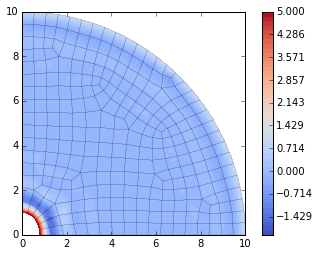

In [5]:
patches = []
for coord in coords[connect[:,0:4]-1]:
    quad = Polygon(coord, facecolor='none', fill=False)
    patches.append(quad)

pres_idx, = np.where(problem.dof_map[:,-1] != -1)
X = coords[pres_idx,0]
Y = coords[pres_idx,1]
grid_x, grid_y = np.mgrid[0:11:700j, 0:11:700j]
p = scipy.interpolate.griddata((X, Y), pressure, (grid_x, grid_y), method='cubic')

interior = np.sqrt((grid_x**2 / 0.8**2) + (grid_y**2 / 1**2)) < 1
p[interior] = np.nan

fig, ax = plt.subplots()
cs = ax.contourf(grid_x, grid_y, p, cmap="coolwarm",levels=np.linspace(-2, 5, 50))
fig.colorbar(cs, ax=ax);
#colors = 100 * np.random.rand(len(patches))


p = PatchCollection(patches, match_original=True)
p.set_linewidth(0.1)
    
#p.set_array(np.array(colors))
ax.add_collection(p)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_aspect('equal')

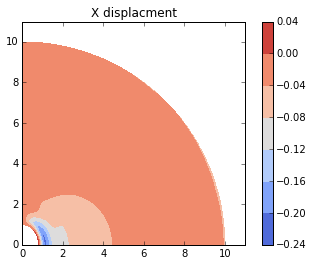

In [6]:
X = coords[:,0]
Y = coords[:,1]
disp_x = scipy.interpolate.griddata((X, Y), displacement[:,0], (grid_x, grid_y), method='cubic')
disp_x[interior] = np.nan
plt.figure()
plt.gca().set_aspect('equal')
plt.contourf(grid_x, grid_y, disp_x, cmap="coolwarm")
plt.colorbar();
plt.title("X displacment");

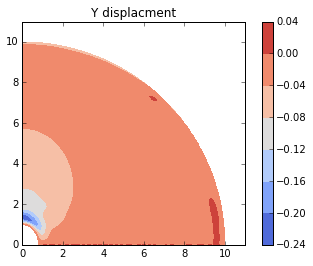

In [7]:
disp_y = scipy.interpolate.griddata((X, Y), displacement[:,1], (grid_x, grid_y), method='cubic')
disp_y[interior] = np.nan
plt.figure()
plt.gca().set_aspect('equal')
plt.contourf(grid_x, grid_y, disp_y, cmap="coolwarm")
plt.colorbar();
plt.title("Y displacment");

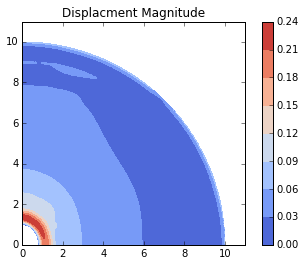

In [8]:
displacement_mag = np.sqrt(displacement[:,0] * displacement[:,0] + displacement[:,1] * displacement[:,1])
disp_mag = scipy.interpolate.griddata((X, Y), displacement_mag, (grid_x, grid_y), method='cubic')
disp_mag[interior] = np.nan
plt.figure()
plt.gca().set_aspect('equal')
plt.contourf(grid_x, grid_y, disp_mag, cmap="coolwarm")#,levels=np.linspace(0.0, 0.06, 50))
plt.colorbar();
plt.title("Displacment Magnitude");

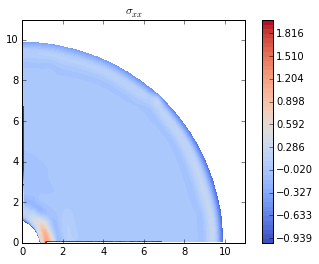

In [9]:
stress = problem.compute_stress(displacement).reshape(-1,3)
x_gauss_pt, y_gauss_pt = problem.compute_gauss_point_locations(deformed_pos)


stress_x = scipy.interpolate.griddata((x_gauss_pt, y_gauss_pt), stress[:,0], (grid_x, grid_y), method='cubic')
stress_y = scipy.interpolate.griddata((x_gauss_pt, y_gauss_pt), stress[:,1], (grid_x, grid_y), method='cubic')
stress_xy = scipy.interpolate.griddata((x_gauss_pt, y_gauss_pt), stress[:,2], (grid_x, grid_y), method='cubic')
stress_x[interior] = np.nan
stress_y[interior] = np.nan
stress_xy[interior] = np.nan


plt.figure()
plt.gca().set_aspect('equal')
plt.contourf(grid_x, grid_y, stress_x, cmap="coolwarm",levels=np.linspace(-1, 2, 50))
plt.colorbar();
plt.title("$\sigma_{xx}$");

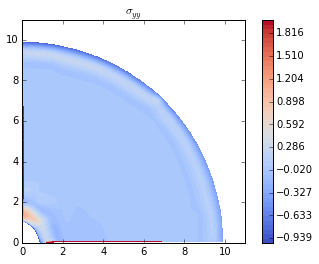

In [10]:
plt.figure()
plt.gca().set_aspect('equal')
plt.contourf(grid_x, grid_y, stress_y, cmap="coolwarm",levels=np.linspace(-1,  2, 50))
plt.colorbar();
plt.title("$\sigma_{yy}$");

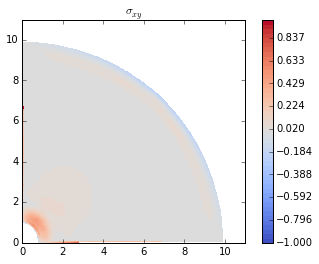

In [11]:
plt.figure()
plt.gca().set_aspect('equal')
plt.contourf(grid_x, grid_y, stress_xy, cmap="coolwarm",levels=np.linspace(-1, 1, 50))
plt.colorbar();
plt.title("$\sigma_{xy}$");